### Importe de librerias

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.utils.vis_utils import plot_model

np.random.seed(1)
tf.random.set_seed(1)

2022-11-30 12:29:55.350616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Redes Neuronales

Datasets a utilizar

In [2]:
#datasets normales
ds_train = pd.read_csv('properati_argentina_train.csv')
ds_test = pd.read_csv('properati_argentina_test.csv')

### Ingenieria de caracteristicas para datasets compelto

In [3]:
ds_train.head()

,Unnamed: 0,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precioxm2_relativo_q
0,0,-34.601807,-58.469965,Departamento,2.0,1.0,53.0,49.0,80000.0,bajo
1,1,-34.580088,-58.424965,Departamento,2.0,1.0,35.0,35.0,79900.0,medio
2,2,-34.551481,-58.452358,Departamento,1.0,1.0,25.0,20.0,69000.0,medio
3,3,-34.632290,-58.464844,Departamento,5.0,3.0,75.0,75.0,150000.0,medio
4,4,-34.549279,-58.463074,Departamento,2.0,1.0,46.0,34.0,85000.0,bajo


In [4]:
#dropeamos Unamed:0
ds_train.drop(columns=["Unnamed: 0"], inplace=True)
ds_test.drop(columns=["Unnamed: 0"], inplace=True)

#cambio nombre de columna precioxm2_relativo_q
ds_train.rename(columns={'precioxm2_relativo_q':'tipo_precio'}, inplace=True)
ds_test.rename(columns={'precioxm2_relativo_q':'tipo_precio'}, inplace=True)

Aplicamos dummies a la variable property_type y precioxm2_relativo_q

In [5]:
ds_train = pd.get_dummies(ds_train, columns=["property_type"], drop_first=True)

ds_test =  pd.get_dummies(ds_test, columns=["property_type"], drop_first=True)

## Regresion

Funcion para graficar

In [9]:
def plot_regression(modelo,x,y,title="",xlabel="x",ylabel="y"):
    plt.figure()
    
    plt.plot(x,y,"o",label="Valores verdaderos")
    plt.plot(x,modelo.predict(x),"x",label="Valores estimados")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [6]:
features_regression = ['longitud', 'latitud', 'property_surface_total']
target_regression = ['property_price']

x_train_regres = ds_train.loc[:, features_regression]
x_test_regres = ds_test.loc[:, features_regression]
y_train_regres = ds_train.loc[:, target_regression]
y_test_regres = ds_test.loc[:, target_regression]

In [7]:
sscaler = StandardScaler()
sscaler.fit(x_train_regres)

StandardScaler()

In [8]:
x_train_regres = sscaler.transform(x_train_regres)
x_test_regres = sscaler.transform(x_test_regres)

#### Modelo de regresion

In [9]:
d_in = len(features_regression)
d_out = len(target_regression)

In [22]:
def regression_model_builder(hp):
    max_neurons = 50
    model = keras.Sequential()
    model.add(keras.Input(shape=(d_in,)))
    
    hp_units_1 = hp.Int('units_1', min_value=d_in, max_value=max_neurons, step=1)
    hp_activation_1 = hp.Choice('activation_1', values=['tanh', 'sigmoid'])
    model.add(keras.layers.Dense(units=hp_units_1, activation=hp_activation_1, name="layer1"))
    
    hp_units_2 = hp.Int('units_2', min_value=d_in, max_value=max_neurons, step=1)
    hp_activation_2 = hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid'])
    model.add(keras.layers.Dense(units=hp_units_2, activation=hp_activation_2, name="layer2"))
    
    model.add(keras.layers.Dense(units=d_out, name="output"))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )
    
    return model

In [23]:
regres_tuner = kt.RandomSearch(
    regression_model_builder,
    objective='val_loss',
    max_trials=20
)

In [24]:
regres_history = regres_tuner.search(x_train_regres, y_train_regres.to_numpy(), epochs=50, validation_split=0.2)

Trial 20 Complete [00h 01m 21s]
val_loss: 19209656320.0

Best val_loss So Far: 19209660416.0
Total elapsed time: 00h 31m 02s
INFO:tensorflow:Oracle triggered exit


In [48]:
best_regres_hps = regres_tuner.get_best_hyperparameters()[0]
print("Hiperparametros Optimos Encontrados")
print("  · Neuronas primera capa: ", best_regres_hps.get('units_1'))
print("  · Activavion primera capa: ", best_regres_hps.get('activation_1'))
print("  · Neuronas segunda capa: ", best_regres_hps.get('units_2'))
print("  · Activavion segunda capa: ", best_regres_hps.get('activation_2'))
print("  · Learning rate: ", best_regres_hps.get('learning_rate'))

Hiperparametros Optimos Encontrados
  · Neuronas primera capa:  22
  · Activavion primera capa:  tanh
  · Neuronas segunda capa:  6
  · Activavion segunda capa:  tanh
  · Learning rate:  0.001


In [26]:
regres_model = regres_tuner.get_best_models()[0]

In [27]:
y_pred_regres = regres_model.predict(x_test_regres)

508/508 [==============================] - 0s 673us/step


In [31]:
regres_rmse = mean_squared_error(
        y_true  = y_test_regres,
        y_pred  = y_pred_regres,
        squared = False
       )

print(f"La raiz del error cuadratico medio del test es: {regres_rmse:,.2f}")

La raiz del error cuadratico medio del test es: 139,737.41


In [43]:
pd.Series(y_pred_regres[:, 0]).unique()

array([178282.81], dtype=float32)

In [44]:
y_train_regres.mean()

property_price    178476.046149
dtype: float64

Pareciera que la red se aprendio el promedio y siempre predice eso.

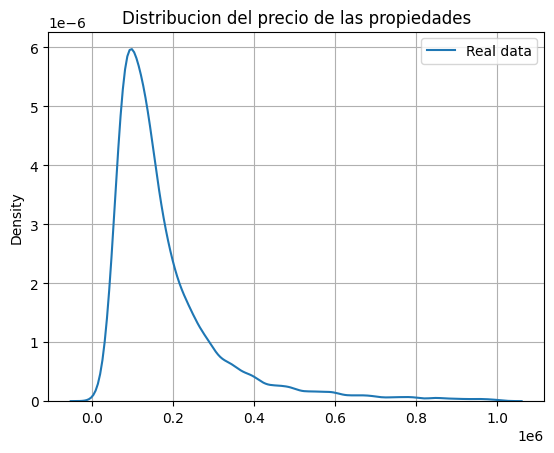

In [33]:
plt.grid(True)
sns.kdeplot(data=y_test_regres, label='Real data')
sns.kdeplot(data=y_pred_regres, label='Predictions')
plt.title("Distribucion del precio de las propiedades")
plt.legend()
plt.show()

In [253]:
val_acc_per_epoch = history.history['root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 1


sacado de:
- https://github.com/karndeepsingh/keras_tuner_implementation/blob/main/HYPER_OPTIMIZATION_OF_DEEP_LEARNING_MODELS_USING_KERAS_TUNER_.ipynb
- https://keras.io/keras_tuner/

### Entrenamos el mejor modelo y lo graficamos

1867/1867 [==============================] - 2s 831us/step


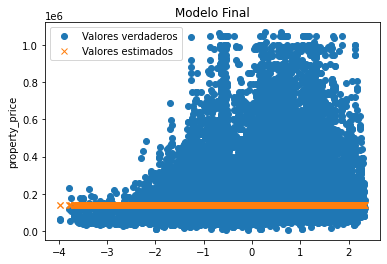

In [254]:
plot_regression(best_model, x_train, y_train, title=f"Modelo Final",xlabel="", ylabel="property_price")

In [255]:
eval_result = best_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

508/508 [==============================] - 0s 943us/step - loss: 21245880320.0000 - root_mean_squared_error: 145759.6719
[test loss, test accuracy]: [21245880320.0, 145759.671875]


### Resultados del modelo

In [256]:
y_pred = best_model.predict(x_test)

mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
rmse=mean_squared_error(y_test, y_pred, squared=False) 

print(f"Error absoluto medio {mae}")
print(f"Error cuadrático medio {mse}")
print(f"Raiz del error cuadrático medio {rmse}")


508/508 [==============================] - 0s 802us/step
Error absoluto medio 86866.51842353621
Error cuadrático medio 21245877667.760246
Raiz del error cuadrático medio 145759.65720239686


## Clasificacion

Dataset iniciales

In [257]:
ds_train.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_type_Departamento,property_type_PH
0,-0.212018,-58.469965,2.0,1.0,53.0,49.0,80000.0,bajo,1,0
1,0.628267,-58.424965,2.0,1.0,35.0,35.0,79900.0,medio,1,0
2,1.735031,-58.452358,1.0,1.0,25.0,20.0,69000.0,medio,1,0
3,-1.391398,-58.464844,5.0,3.0,75.0,75.0,150000.0,medio,1,0
4,1.820228,-58.463074,2.0,1.0,46.0,34.0,85000.0,bajo,1,0


In [258]:
ds_test.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_type_Departamento,property_type_PH
0,-0.091010,-58.499717,1.0,1.0,38.0,28.0,85000.0,medio,1,0
1,0.825624,-58.420611,2.0,1.0,150.0,70.0,520000.0,alto,1,0
2,0.379128,-58.398279,2.0,1.0,43.0,41.0,87000.0,medio,1,0
3,0.722699,-58.406064,4.0,3.0,130.0,118.0,690000.0,alto,1,0
4,1.366830,-58.464248,1.0,1.0,33.0,29.0,95000.0,alto,1,0


Declaro variables predictoras, de target y a eliminar

In [259]:
#Eliminamos columnas que esten relaionadas con el precio
columnas_a_eliminar = ["property_price", "property_bedrooms", "property_surface_total", "property_surface_covered", "property_price", "property_type_Departamento", "property_type_PH"]

#target
target = ["tipo_precio"]

#columnas_predictoras 
columnas_predictoras = ["latitud", "longitud", "property_rooms"]


Preparo los dataset para entrenamiento y testeo

In [260]:
ds_train_clas = ds_train.drop(columns=columnas_a_eliminar)
ds_test_clas = ds_test.drop(columns=columnas_a_eliminar)

#train
x_train = ds_train_clas.drop(columns=target)
y_train = ds_train_clas[target]

#test
x_test = ds_test_clas.drop(columns=target)
y_test = ds_test_clas[target]

Remplazo tipo_precio por numeros

- bajo = 0
- medio = 1
- alto = 2

In [261]:
y_train["tipo_precio"] = y_train["tipo_precio"].replace({"bajo": 0, "medio": 1, "alto" : 2})
y_test["tipo_precio"] = y_test["tipo_precio"].replace({"bajo": 0, "medio": 1, "alto" : 2})

C:\Users\EQUIPO~1\AppData\Local\Temp/ipykernel_9772/1025328752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train["tipo_precio"] = y_train["tipo_precio"].replace({"bajo": 0, "medio": 1, "alto" : 2})
C:\Users\EQUIPO~1\AppData\Local\Temp/ipykernel_9772/1025328752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["tipo_precio"] = y_test["tipo_precio"].replace({"bajo": 0, "medio": 1, "alto" : 2})


In [262]:
y_train.head()

,tipo_precio
0,0
1,1
2,1
3,1
4,0


In [263]:
y_test.head()

,tipo_precio
0,1
1,2
2,1
3,2
4,2


### Creacion y entrenamiento del modelo

In [264]:
# calcula la cantidad de clases
cant_clases=len(np.unique(y_train))

d_in=len(columnas_predictoras)

modelo = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 3 salidas, activación relu
    keras.layers.Dense(3,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    keras.layers.Dense(3,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    keras.layers.Dense(cant_clases, activation='softmax')])

modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 3)                 12        
                                                                 
 dense_9 (Dense)             (None, 3)                 12        
                                                                 
 dense_10 (Dense)            (None, 3)                 12        
                                                                 
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


In [265]:
modelo.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.001), 
  loss='categorical_crossentropy', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['AUC'], 
)

cant_epochs=100

historia_modelo=modelo.fit(x_train,y_train,epochs=cant_epochs,batch_size=16,verbose=False)

ValueError: in user code:

    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


In [ ]:
y_pred = modelo.predict(x_test)

y_pred = np.argmax(y_pred,axis = 1) 

print("  Accuracy : %.2f" % accuracy_score(y_test, y_pred) )
print("  Precision: %.2f" % precision_score(y_test, y_pred) )
#print("     Recall: %.2f" % recall_score(y_test, y_pred ))
#print("  f-measure: %.2f" % f1_score(y_test, y_pred))

508/508 [==============================] - 0s 921us/step
  Accuracy : 0.25


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].